# See README first

In [209]:
import sys
import csv
from langdetect import detect
import nltk
from nltk.corpus import stopwords
import string
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
lem = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/francisbian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [242]:
csv.field_size_limit(sys.maxsize)
print(string.punctuation)
stop_words = set(stopwords.words('english'))
additional_word = set(['im', 'get', 'say', 'go', 'dont', 'know'])
stop_words = stop_words.union(additional_word)
print(stop_words)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
{'am', 'with', 'after', 'was', 'both', "should've", 'at', 'most', 'yourselves', 'or', 'how', 'hers', 'some', 'over', 'about', 'they', "haven't", "didn't", "hadn't", 'just', "wouldn't", "wasn't", 'herself', 'do', 'up', 'should', 'why', 'mightn', 'him', 'themselves', 'a', 'im', 'further', 'having', 'no', 'needn', 'aren', 'too', 'did', "mightn't", 'ours', 'shan', 'ma', 'can', 'these', 'out', 'were', 'will', 'theirs', 'does', 'same', "shouldn't", 'against', 'than', 'he', 've', 'not', 'had', "it's", 'know', 'each', 'where', 'more', 're', "couldn't", 'ain', 'mustn', 'wasn', 'those', 'shouldn', 'again', 'under', 'o', 'for', "isn't", "needn't", 'weren', 'say', 'then', 'here', 'our', 'being', "you're", 'whom', 'me', 'their', 'his', 'an', 'until', 'into', 'itself', 'which', 'myself', 'i', 'below', 'all', "doesn't", 'isn', 'what', 'are', 'before', 'hasn', 'of', 'couldn', 'go', 'himself', "weren't", "she's", 'll', 'own', 's', 'if', "hasn't", 'down', "that'll", 'the

# For the hot100 dataset
## In general:
#### 1) Artist owns the most songs that appears in billboard?
#### 2) Artist appears most in billboard (by cnt)?
#### 3) How many songs will be in the 52 weekly hot100 list per year? - around 400 - 800
#### 4) Songs that appear in the hot100 list most.
#### 5) Artist whose song always achieved a high rank on the list.
#### 6) Song appears/gaps in most years


## Changes through years:
#### 1) commonly used words of lyrics - How they differed and how aligned?
#### 2) What is the average (highest) rank of songs?
#### 3) How many artists show up in the billboard ever year?
#### 4) Does the average number of occurrence of the hot100 songs increase/decrease each year?
#### 5) How about the length of lyrics?

## Interesting things:
#### 1) Songs/Artists that appear again in the hotlist after a long period. 
#### 2) Songs become hot way later than its release date.
#### 3) Songs are popular until nowadays

In [262]:
# For test the unit functions
df = pd.read_csv('../combined_dataset/lyrics&features_{}.csv'.format(1960))

In [243]:
# Extract the bag of words for an entire year. Then we could do TF-IDF or text-based analysis.
def get_yearly_word_list(df):
    yearly_word_list = []
    for i in range(len(df)):
        li = df.loc[i,'words'].replace('\'', '')
        li = li.strip('][').split(', ') 
        if len(li) != 0:
            yearly_word_list += [w for w in li if w not in stop_words]
    return yearly_word_list

In [147]:
# Get average length of the lyrics from this year
# Exclude the top 3 longest and 3 shortest
def get_average_length(df, exclude=3):
    sorted_valid_length = sorted([df.loc[i, 'lyrics_length'] for i in range(len(df)) if df.loc[i, 'lyrics_length'] != 0])
    sorted_valid_length = sorted_valid_length[exclude: len(sorted_valid_length) - exclude]
    return sum(sorted_valid_length)/len(sorted_valid_length)

In [259]:
# Get average occurrence of songs in this year's billboard 
def get_average_occ(df):
    return sum([df.loc[i, 'cnt'] for i in range(len(df))])/len(df)

In [375]:
# Get average highest rank
def get_average_highest_rank(df):
    rank_list = []
    for i in range(len(df)):
        rk = df.loc[i,'rank'].replace('\'', '')
        rk = rk.strip('][').split(', ') 
        rk = [int(i) for i in rk] 
        if len(rk) != 0:
            rank_list.append(min(rk))
    return sum(rank_list)/len(rank_list)

In [274]:
# Get the artists of this year
def get_yearly_artists(df):
    artists = set()
    for i in range(len(df)):
        artists.add(df.loc[i,'artists'])
    return artists

In [397]:
def update_songs(df, year, songs_years_ranks):
    for i in range(len(df)):
        title = df.loc[i, 'title']
        key = title + " by " + df.loc[i, 'artists']
        rk = df.loc[i,'rank'].replace('\'', '')
        rk = rk.strip('][').split(', ') 
        rk = [int(i) for i in rk]
        if len(rk) == 0:
            continue
        
        if key not in songs_years_ranks:
            songs_years_ranks[key] = defaultdict(list)
            songs_years_ranks[key][year] = rk
        else:
            songs_years_ranks[key][year] = rk

In [398]:
# Get the released month of the hottest 5 songs
# def get_released_month(df):
    

## Perform on all the dataset

In [416]:
# key: year, val: Bags of word in this year
yearly_words_dict = {}
# key: year, val: average length of lyrics in this year
yearly_length_dict = {}
# key: year, val: average occurrence in this year's billboard for songs
yearly_average_occ = {}
# key: year, val: artists that are in the billboard in this year
yearly_artists_dict = {}
# key: song_title, val:{key: year, val: ranks of this song is this year}
songs_years_ranks = {}
# key: year, val: average rank of each song is this year
yearly_average_highest_rank = {}
# key: artist, val: songs by this artist that in the billboard hotlist
artist_songs_dict = defaultdict(set)
# key: artist, val: number of occurrence in billboard
artist_occ_dict = defaultdict(int)

artist_set = set()
song_set = set()

In [400]:
for year in range(1960, 2021):
    df = pd.read_csv('../combined_dataset/lyrics&features_{}.csv'.format(year))
    for i in range(len(df)):
        # artist_set.add(df.loc[i, 'artist_name'])
        artist_set.add(df.loc[i, 'artists'])
        song_set.add(df.loc[i, 'title'])
        
        artist_songs_dict[df.loc[i, 'artists']].add(df.loc[i, 'title'])
        artist_occ_dict[df.loc[i, 'artists']] += (int)(df.loc[i, 'cnt'])
        
    yearly_length_dict[year] = get_average_length(df)
    yearly_artists_dict[year] = get_yearly_artists(df)
    yearly_words_dict[year] = get_yearly_word_list(df)
    yearly_average_occ[year] = get_average_occ(df)
    update_songs(df, year, songs_years_ranks)
    yearly_average_highest_rank[year] = get_average_highest_rank(df)
    #yearly_released_month[year] = get_released_month(df)
    

### Some changes (length, rank, occurrence) according to the years

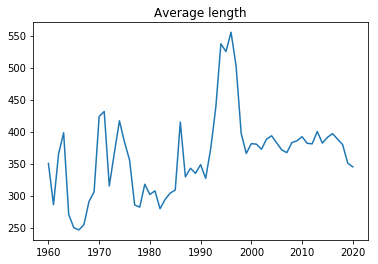

In [205]:
plt.title("Average length")
plt.plot([v for k,v in yearly_length_dict.items()])
positions = [i for i in range(0, 61, 10)]
labels = [(str)(i + 1960) for i in range(0, 61, 10)]
plt.xticks(positions, labels)
plt.locator_params(axis='x', nbins=8)

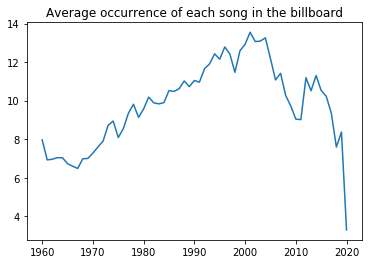

In [206]:
plt.title("Average occurrence of each song in the billboard")
plt.plot([v for k,v in yearly_average_occ.items()])
positions = [i for i in range(0, 61, 10)]
labels = [(str)(i + 1960) for i in range(0, 61, 10)]
plt.xticks(positions, labels)
plt.locator_params(axis='x', nbins=8)

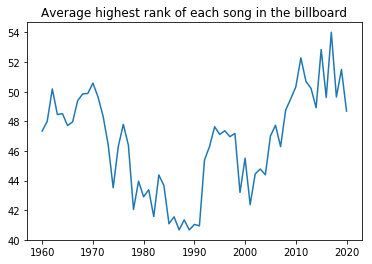

In [383]:
plt.title("Average highest rank of each song in the billboard")
plt.plot([v for k,v in yearly_average_highest_rank.items()])
positions = [i for i in range(0, 61, 10)]
labels = [(str)(i + 1960) for i in range(0, 61, 10)]
plt.xticks(positions, labels)
plt.locator_params(axis='x', nbins=8)

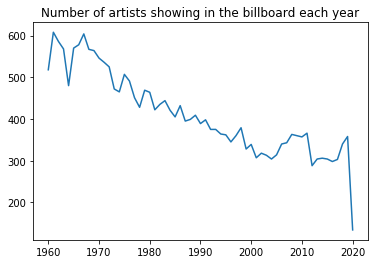

In [277]:
plt.title("Number of artists showing in the billboard each year")
plt.plot([len(v) for k,v in yearly_artists_dict.items()])
positions = [i for i in range(0, 61, 10)]
labels = [(str)(i + 1960) for i in range(0, 61, 10)]
plt.xticks(positions, labels)
plt.locator_params(axis='x', nbins=8)

#### TFIDF?

In [246]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([' '.join(yearly_words_dict[year]) for year in range(1960, 2021)])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [247]:
for index, row in df.iterrows():
    df = df.sort_values(by=index, axis=1, ascending=False)
    print(df.columns[0:10])

Index(['like', 'love', 'come', 'tell', 'mam', 'one', 'want', 'malachy', 'take',
       'make'],
      dtype='object')
Index(['dirk', 'love', 'like', 'come', 'oh', 'let', 'tell', 'baby', 'one',
       'make'],
      dtype='object')
Index(['mam', 'like', 'tell', 'come', 'malachy', 'love', 'one', 'want', 'make',
       'take'],
      dtype='object')
Index(['like', 'love', 'one', 'come', 'make', 'tony', 'see', 'time', 'labour',
       'look'],
      dtype='object')
Index(['love', 'like', 'oh', 'baby', 'coulson', 'come', 'one', 'yeah', 'see',
       'make'],
      dtype='object')
Index(['love', 'like', 'baby', 'oh', 'come', 'see', 'make', 'one', 'time',
       'yeah'],
      dtype='object')
Index(['love', 'like', 'baby', 'come', 'make', 'oh', 'see', 'yeah', 'time',
       'want'],
      dtype='object')
Index(['love', 'come', 'baby', 'like', 'oh', 'make', 'time', 'see', 'take',
       'let'],
      dtype='object')
Index(['love', 'like', 'come', 'nat', 'baby', 'one', 'make', 'oh', 'see',
    

### General and interesting findings

In [351]:
## In general:
#### 1) Artist owns the most songs that appears in billboard?
#### 2) Artist appears most in billboard (by cnt)?
#### 3) How many songs will be in the 52 weekly hot100 list per year? - around 400 - 800
#### 4) Songs that appear in the hot100 list most.
#### 5) Artist whose song always achieved a high rank on the list.
#### 6) Song appears/gaps in most years

## Interesting things:
#### 1) Songs/Artists that appear again in the hotlist after a long period. 
#### 2) Songs become hot way later than its release date.
#### 3) Songs are popular until nowadays

#### 1) Artist owns the most songs that appears in billboard?

In [311]:
artist_songs_count = {a:len(b) for a,b in artist_songs_dict.items()}
sorted_artists = sorted(artist_songs_count.items(), key=lambda x: x[1], reverse=True)
print(sorted_artists[:5])

[('Drake', 172), ('Eminem', 111), ('Elvis Presley', 96), ('Kanye West', 85), ('Taylor Swift', 81)]


#### 2) Artist appears most in billboard (by cnt)?

In [312]:
sorted_artists_occ = sorted(artist_occ_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_artists_occ[:5])

[('Drake', 2450), ('Eminem', 1827), ('Kanye West', 1518), ('The Weeknd', 1265), ('JAY-Z', 1225)]


#### 4) Songs that appear in the hot100 list most.

In [404]:
songs_count = {}
for k,v in songs_years_ranks.items():
    songs_count[k] = sum([len(ranks) for y,ranks in v.items()])
sorted_songs_count = sorted(songs_count.items(), key=lambda x: x[1], reverse=True)
print(sorted_songs_count[:5])

[('Stay by Zedd & Alessia Cara', 206), ('Angel by The Weeknd', 205), ('Heaven by JAY-Z', 194), ('Hold On by Chord Overstreet', 189), ('I Like It by Cardi B, Bad Bunny & J Balvin', 188)]


#### 5) Artist whose song always achieved a high rank on the list.

In [390]:
artist_average_rank = {}
for artist, songs in artist_songs_dict.items():
    for song in songs:
        ranks = []
        minRank = 101
        for year, ranks in songs_years_ranks[song + " by " + artist].items():
            minRank = min(minRank, min(ranks))
        ranks.append(minRank)
    artist_average_rank[artist] = sum(ranks)/len(ranks)
sorted_songs_count = sorted(artist_average_rank.items(), key=lambda x: x[1])
print(sorted_songs_count[:5])

[('Brenda Lee', 2.0), ('Roddy Ricch', 2.272727272727273), ('Lewis Capaldi', 5.181818181818182), ('John Fred & His Playboy Band', 5.866666666666666), ('Dan + Shay & Justin Bieber', 6.818181818181818)]


#### 6) Song appears/gaps in most years

In [412]:
songs_appears = {a:len(b) for a,b in songs_years_ranks.items()}
sorted_songs_appears = sorted(songs_appears.items(), key=lambda x: x[1], reverse=True)
print("Songs that shows in the billboard in most years")
print(sorted_songs_appears[:5])

Songs that shows in the billboard in most years
[('You by Ed Sheeran', 16), ('Angel by The Weeknd', 15), ('Hold On by Chord Overstreet', 14), ('Stay by Zedd & Alessia Cara', 13), ('Crazy by Gnarls Barkley', 13)]


In [415]:
songs_years = {a:sorted(b)[len(b) - 1] - sorted(b)[0] for a,b in songs_years_ranks.items()}
sorted_songs_years = sorted(songs_years.items(), key=lambda x: x[1], reverse=True)
print("Songs that covers most years")
print(sorted_songs_years[:5])

Songs that covers most years
[("Rockin' Around The Christmas Tree by Brenda Lee", 60), ('White Christmas by Bing Crosby', 60), ('Jingle Bell Rock by Bobby Helms', 60), ('The Christmas Song (Merry Christmas To You) by Stevie Wonder', 60), ('Blue Christmas by Elvis Presley', 60)]


In [414]:
songs_years_ranks['The Christmas Song (Merry Christmas To You) by Stevie Wonder']

defaultdict(list,
            {1960: [80, 100],
             1962: [65, 67, 75],
             2014: [45],
             2016: [38],
             2017: [38, 42, 47],
             2018: [17, 24, 29, 39, 42, 37],
             2019: [30, 32, 33, 11],
             2020: [16]})

# For the spotify feature dataset

## In general:
#### 1) 

## Changes through years:
#### 1) Duration?
#### 2) How about the released month of top 5 songs each year?

## Interesting things:
#### 1) 